# Definitions of regions for contribution calculations


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap, cm
import netCDF4 as nc
import cmocean
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
import pickle
import matplotlib
from matplotlib.patches import Polygon 

%matplotlib notebook

###### Parameters:

In [3]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax-imin
jsize = jmax-jmin

# colours:
land_color = "#8b7765"

###### Load files:

In [4]:
mesh       = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh1.nc')
mesh_lon   = np.array(mesh.variables['nav_lon'])
mesh_lat   = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])

In [5]:
mask     = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh_zgr10.nc')
tmask    = np.array(mask.variables['tmask'][0,:,:,:])
Z_masked = np.ma.masked_where((tmask > 0.1), tmask) 

##### Calculations:

In [6]:
# Find indices to separate out Canada Basin:

x_ind = np.arange(1620, 2100, 1)
y_ind = (-7/8)*x_ind + 1517 + 700

CB_indx = []
CB_indy = []

for index in range(0,len(x_ind)):
    CB_x = np.arange(x_ind[index],2180,1)
    CB_y = np.ones(CB_x.shape)*y_ind[index]
    
    CB_indx = np.append(CB_x, CB_indx)
    CB_indy = np.append(CB_y, CB_indy)

In [7]:
# Separate Canada Basin and the CAA:

mask_ini_CB  = np.zeros((isize,jsize))
mask_ini_CAA = np.ones((isize,jsize))

for i, j in zip(CB_indx, CB_indy):
    mask_ini_CB[int(i-imin),int(j-jmin)]  = 1
    mask_ini_CAA[int(i-imin),int(j-jmin)] = 0
    
mask_ini_CB[150:-1 ,-8:-1] = 1
mask_ini_CAA[150:-1,-8:-1] = 0

# # Mask the boundaries:
# mask_ini_CB[-5:-1,:] = 0
# mask_ini_CB[:,-10:-1] = 0
# mask_ini_CAA[0:10,:]  = 0

In [8]:
# Separate the western and eastern CAA:

mask_ini_wCAA = np.where(mesh_lon[imin:imax,jmin:jmax] < -100, 1, 0)
mask_ini_eCAA = np.where(mesh_lon[imin:imax,jmin:jmax] > -100, 1, 0)

for i, j in zip(CB_indx, CB_indy):
    mask_ini_wCAA[int(i-imin),int(j-jmin)] = 0
    mask_ini_eCAA[int(i-imin),int(j-jmin)] = 0
    
mask_ini_wCAA[150:-1,-8:-1] = 0
mask_ini_eCAA[150:-1,-8:-1] = 0

# # Mask the boundaries:
# mask_ini_wCAA[0:10,:]   = 0
# mask_ini_wCAA[-5:-1,:] = 0
# mask_ini_eCAA[0:10,:]   = 0
# mask_ini_eCAA[:,-10:-1] = 0

##### Figures:

<IPython.core.display.Javascript object>


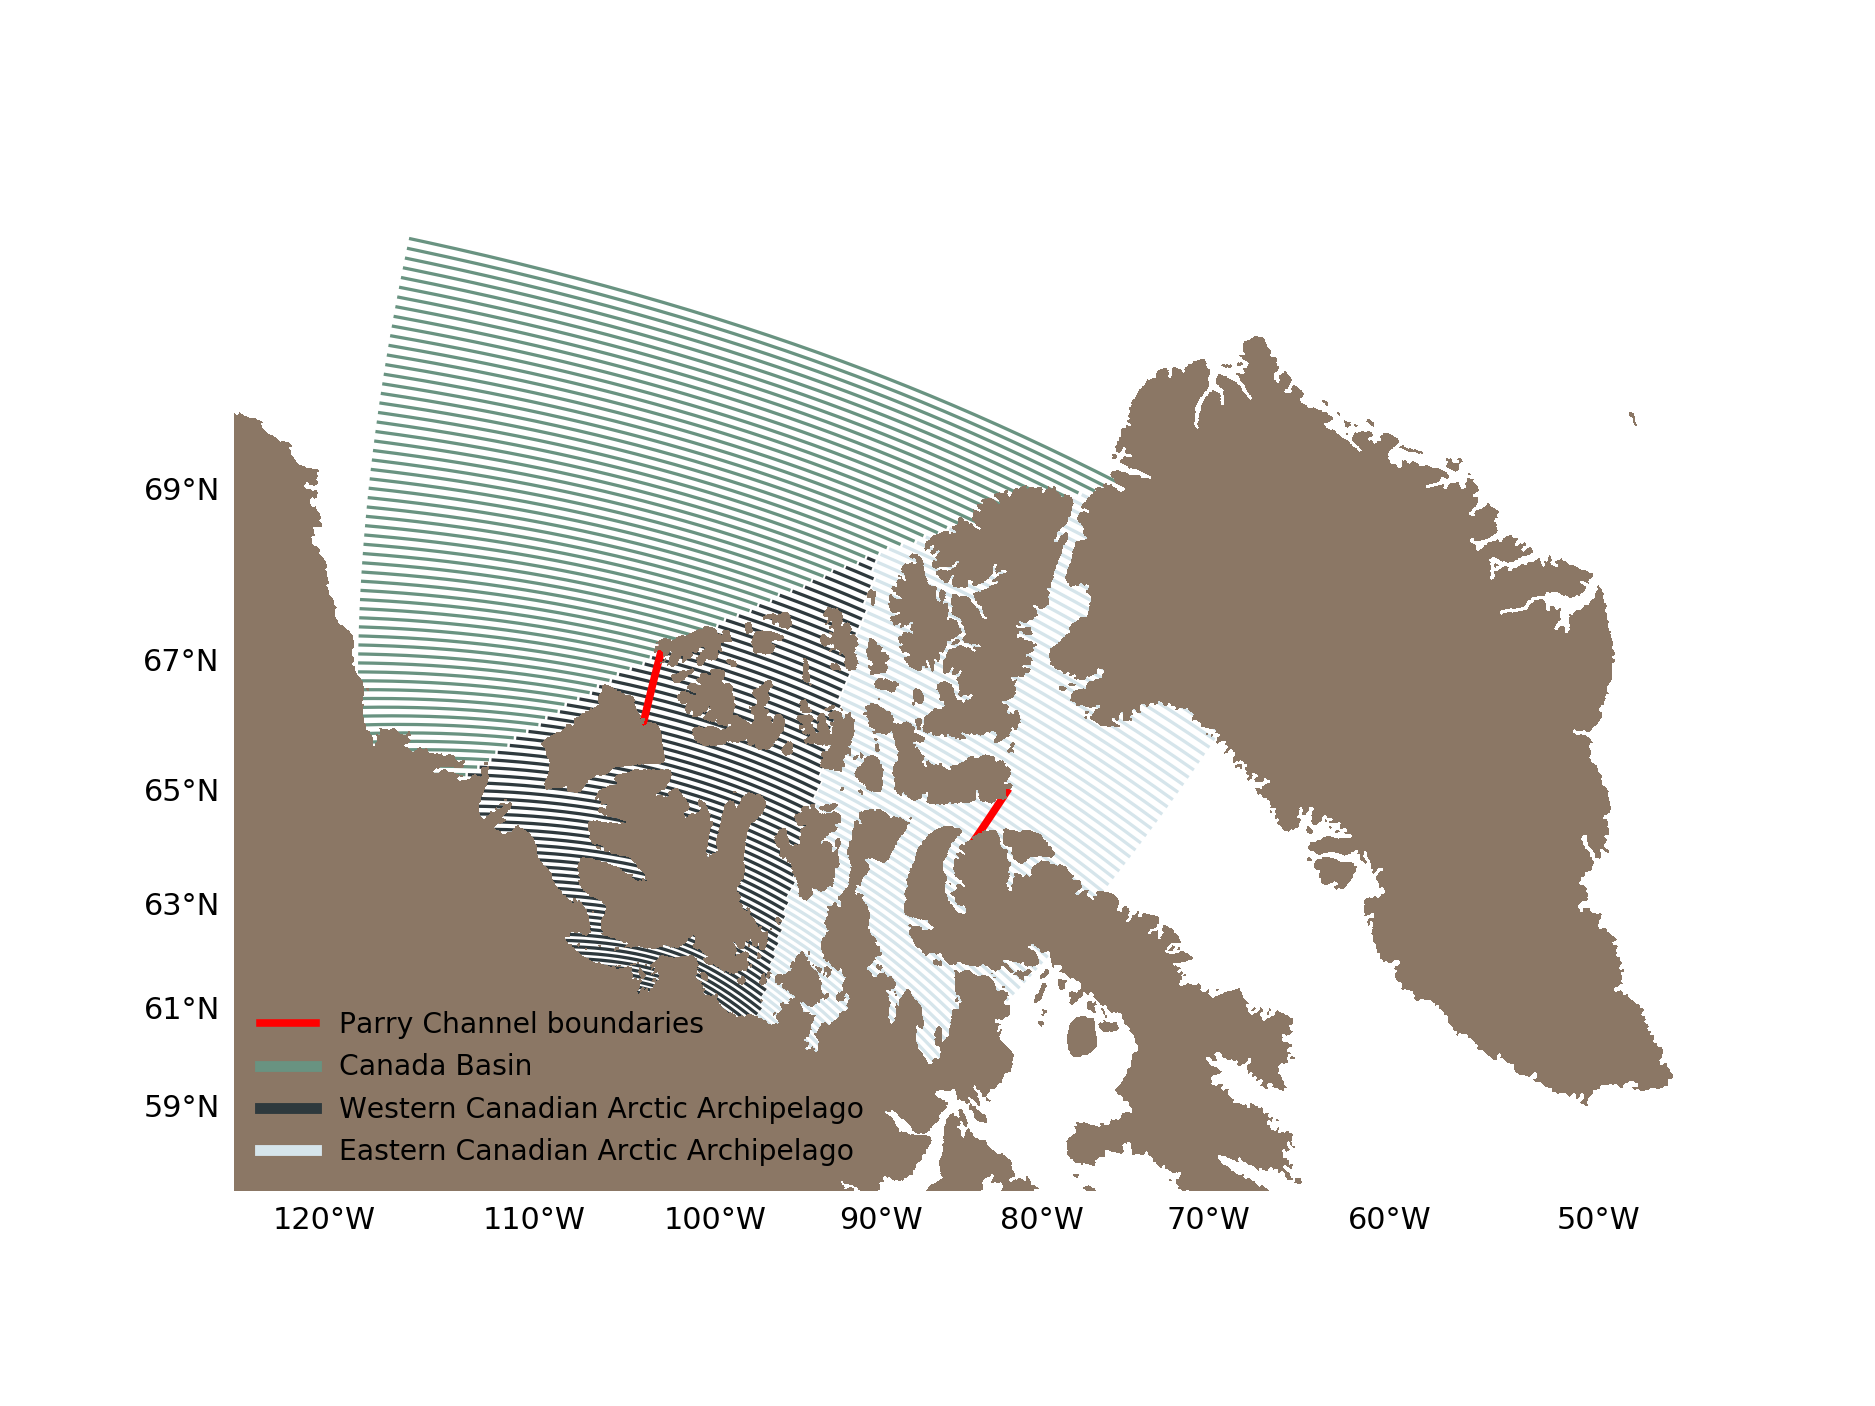

In [9]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','rb'))

# Sub-domain map: ---------------------------------------------------------------------------
x_sub, y_sub  = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax]) 
# proj1.plot(x_sub[0,:]   , y_sub[0,:]   , 'k-', lw=1.5, zorder=3)
# proj1.plot(x_sub[-1,:]  , y_sub[-1,:]  , 'k-', lw=1.5, zorder=3)
# proj1.plot(x_sub[:,0]   , y_sub[:,0]   , 'k-', lw=1.5, zorder=3)
# proj1.plot(x_sub[:,-1]  , y_sub[:,-1]  , 'k-', lw=1.5, zorder=3)

res1=5
res2=7

proj1.plot(np.ma.masked_where(mask_ini_CB[::res1,::res2]==0  , x_sub[::res1,::res2]), \
           np.ma.masked_where(mask_ini_CB[::res1,::res2]==0  , y_sub[::res1,::res2]), '-', c='#699381');
proj1.plot(np.ma.masked_where(mask_ini_wCAA[::res1,::res2]==0, x_sub[::res1,::res2]), \
           np.ma.masked_where(mask_ini_wCAA[::res1,::res2]==0, y_sub[::res1,::res2]), '-', c='#2e393d');
proj1.plot(np.ma.masked_where(mask_ini_eCAA[::res1,::res2]==0, x_sub[::res1,::res2]), \
           np.ma.masked_where(mask_ini_eCAA[::res1,::res2]==0, y_sub[::res1,::res2]), '-', c='#d6e5eb');

x_full, y_full = proj1(mesh_lon, mesh_lat) 

proj1.plot(x_full[1935,450:530], y_full[1935,450:530], '-r', linewidth=3.5, label='Parry Channel boundaries')
proj1.plot(x_full[1585,485:538], y_full[1585,485:538], '-r', linewidth=3.5)

proj1.plot(0,0, '-', c='#699381', lw=5, label='Canada Basin');
proj1.plot(0,0, '-', c='#2e393d', lw=5, label='Western Canadian Arctic Archipelago');
proj1.plot(0,0, '-', c='#d6e5eb', lw=5, label='Eastern Canadian Arctic Archipelago');

ax1.legend(fontsize=13, frameon=False, loc=3)

x_model, y_model = proj1(mesh_lon, mesh_lat)
proj1.contourf(x_model, y_model, Z_masked[0,:,:], vmax=0.3, cmap=matplotlib.colors.ListedColormap([land_color]), zorder=5)
p = Polygon([(0, 0),(0, 400478),(1.427e6, 400478),(1.427e6, 0)], facecolor=land_color,edgecolor=land_color) 
plt.gca().add_patch(p) 

fig.savefig('/ocean/brogalla/GEOTRACES/figures/A7-region-definitions.png', bbox_inches='tight', dpi=300)